<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 9: Logistic Regression and Sentiment Analysis</h2>
<br>

This notebook introduces the use of logistic regression in Python with an application to sentiment analysis. 

Sentiment analysis is the task of classifying text documents according to the sentiment expressed by the writer (or speaker in case of a transcription). Sentiment analysis has several applications in areas such as marketing, where online comments, reviews, and messages provide a wealth of data about customers that can be leveraged towards improved brand and customer relationship management strategies. 

One way to approach this problem is to use a [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model). In a bag of words model, we represent the document as a numerical vector, where each element of the vector counts the number or times a word (or sequence of words) appears in the document, or simply whether the word appears in the text (leading to a binary vector).  This is of course a substantial simplification since it disregards the linguistic structure of the document. 


<a href="#Twitter-Airline-Sentiment-Data">Twitter Airline Sentiment Data</a> <br>
<a href="#Text-Processing">Text Processing</a> <br>
<a href="#Train-Test-Split">Train-Test Split</a> <br>
<a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Feature-Engineering">Feature Engineering</a> <br>
<a href="#Logistic-Regression">Logistic Regression</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings.

In [57]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [58]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score

### 1. Twitter Airline Sentiment Data

In this lesson we use the [Twitter Arline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) dataset scraped by a company called [Crowdflower](https://www.crowdflower.com/) and made available [Kaggle datasets](https://www.kaggle.com/datasets) page. To build this dataset, the data scientists at Crowdflower scraped all tweets addressed at US airlines in the month of February 2015, including metadata about the message. Human contributors then categorised each tweet according to the sentiment (positive, neutral, or negative) expressed by the author, which can be done through services like [Amazon Mechanical Turk](https://www.mturk.com/).

In [60]:
data=pd.read_csv('Data/Tweets.csv')
data.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In sentiment analysis, it is common to use hierachical classifiers that first classify a document as expressing a neutral or non-neutral sentiment, and then classify the sentiment in the documents that are predicted to have polarity. Therefore, we simplify our analysis to consider only positive and negatives tweets. Furthermore, we only keep the tweets that were classified with full confidence by the human workers. 

In [61]:
data=data[data['airline_sentiment']!='neutral']
data=data[data['airline_sentiment_confidence']==1.0]

The filtered dataset has 8897 observations.

In [62]:
len(data)

8897

**Problem formulation:**  our objective to build a classifier that achieves maximum accuracy in distiguishing positive and negative messages.

Here are examples of negative and positive tweets respectively.

In [63]:
data.loc[4126, 'text']

'@united stuck here in IAH waiting on flight 253 to Honolulu for 7 hours due to maintenance issues. Could we have gotten a new plane!?!? Fail'

In [64]:
data.loc[8644, 'text']

'@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!'

### 2. Text Processing

Text analysis requires careful processing of the raw text data to convert documents into a format that is amenable to analysis. We implement four steps: 

<ol style="margin-left: -10px">
  <li style="margin-top: 12px;"> Tokenization: separate the text into tokens (words) for a bag of words representation.</li>
  <li style="margin-top: 12px;">Removing uninformative punctuation.</li>
  <li style="margin-top: 12px;">Removing stopwords (non-discriminative words such as "the" and "to").</li>
  <li style="margin-top: 12px;">Stemming and lemmatization: converting words into a root form. Say, it can be more useful to consider "democracy", "democracies", "democratic", and "democratization" as the same token.</li>
</ol>

If this is your first time using the [Natural Language Toolkit](https://www.nltk.org/) package, you'll have to do the following to download the corpora. 

In [65]:
import nltk
# nltk.download()

I'll illustrate the process for a single tweet. First, we convert the text into tokens.

In [66]:
from nltk.tokenize import TweetTokenizer

tweet=data.loc[8644, 'text'] 
Tokenizer = TweetTokenizer()
tokenized = Tokenizer.tokenize(tweet)


print('Original:')
print(tweet)
print('\nTokenized:')
print(tokenized)

Original:
@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!

Tokenized:
['@JetBlue', 'had', 'a', 'great', 'flight', 'to', 'Orlando', 'from', 'Hartford', 'a', 'few', 'weeks', 'ago', '!', 'Was', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early', '!']


Second, we remove the punctuation and convert all characters to lowercase. The exclamation mark may be informative about the sentiment, so I'll keep it as a token.

In [67]:
import string
punctuation = list(string.punctuation)
punctuation.remove('!')
tokenized_no_punctuation=[word.lower() for word in tokenized if word not in punctuation]
print(tokenized_no_punctuation)

['@jetblue', 'had', 'a', 'great', 'flight', 'to', 'orlando', 'from', 'hartford', 'a', 'few', 'weeks', 'ago', '!', 'was', 'great', 'to', 'get', 'out', 'on', 'time', 'and', 'arrive', 'early', '!']


Third, we remove the stopwords.

In [68]:
from nltk.corpus import stopwords
tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
print(tokenized_no_stopwords)

['@jetblue', 'great', 'flight', 'orlando', 'hartford', 'weeks', 'ago', '!', 'great', 'get', 'time', 'arrive', 'early', '!']


There are different methods for stemming and lemmatization available in the NLTK package. We pick one below.

In [69]:
from nltk.stem.porter import PorterStemmer
tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords]
print(tokens)

['@jetblu', 'great', 'flight', 'orlando', 'hartford', 'week', 'ago', '!', 'great', 'get', 'time', 'arriv', 'earli', '!']


We put all these steps below into a function that we can apply to the tweets to create a data column containing the tokens. 

In [70]:
# this cell may take over a minute to run

def process_text(text):
    tokenized = Tokenizer.tokenize(text)
    punctuation = list(string.punctuation)
    punctuation.remove('!')
    tokenized_no_punctuation=[word.lower() for word in tokenized if word not in punctuation]
    tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    return tokens

# Applies the process_text function separately to each element of the column 'text' 
data['tokens']=data['text'].apply(process_text)      

Let's have a look at the results. 

In [71]:
data[['text','tokens']].head(10)

,text,tokens
3,@VirginAmerica it's really aggressive to blast...,"[@virginamerica, realli, aggress, blast, obnox..."
4,@VirginAmerica and it's a really big bad thing...,"[@virginamerica, realli, big, bad, thing]"
5,@VirginAmerica seriously would pay $30 a fligh...,"[@virginamerica, serious, would, pay, 30, flig..."
9,"@VirginAmerica it was amazing, and arrived an ...","[@virginamerica, amaz, arriv, hour, earli, good]"
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,"[@virginamerica, <3, pretti, graphic, much, be..."
12,@VirginAmerica This is such a great deal! Alre...,"[@virginamerica, great, deal, !, alreadi, thin..."
14,@VirginAmerica Thanks!,"[@virginamerica, thank, !]"
16,@VirginAmerica So excited for my first cross c...,"[@virginamerica, excit, first, cross, countri,..."
17,@VirginAmerica I flew from NYC to SFO last we...,"[@virginamerica, flew, nyc, sfo, last, week, f..."
18,I ❤️ flying @VirginAmerica. ☺️👍,"[❤, fli, @virginamerica, ☺, 👍]"


Finally, we build the numerical response variable. 

In [72]:
data['positive']=(data['airline_sentiment']=='positive').astype(int)
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tokens,positive
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"[@virginamerica, realli, aggress, blast, obnox...",0
4,570300817074462722,negative,1.0,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),"[@virginamerica, realli, big, bad, thing]",0
5,570300767074181121,negative,1.0,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),"[@virginamerica, serious, would, pay, 30, flig...",0
9,570295459631263746,positive,1.0,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada),"[@virginamerica, amaz, arriv, hour, earli, good]",1
11,570289724453216256,positive,1.0,NaN,NaN,Virgin America,NaN,HyperCamiLax,NaN,0,@VirginAmerica I &lt;3 pretty graphics. so muc...,NaN,2015-02-24 10:30:40 -0800,NYC,America/New_York,"[@virginamerica, <3, pretti, graphic, much, be...",1


Let's save our work so far. We only keep the columns which we are going to use later. 

In [73]:
data=data[['airline','tokens','airline_sentiment','positive']]
data.to_hdf('Data/tweets_processed.h5', 'data')

### 3. Train-Test Split

We need to split the data into training and test sets before exploratory data analysis. 

In [74]:
# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, 
                                            random_state=1, stratify=data['positive'])

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

Stratification means the training and test sets have the same proportion of negative and positive messages. 

### 4. Exploratory Data Analysis

**4.1 Proportion of positive versus negative messages**

We start with some exploratory data analysis for the training data. We find that overall 83% of the tweets are negative and 17% are positive.

In [75]:
train['airline_sentiment'].value_counts()

negative    5167
positive    1060
Name: airline_sentiment, dtype: int64

In [76]:
train['airline_sentiment'].value_counts(normalize=True).round(3)

negative    0.83
positive    0.17
Name: airline_sentiment, dtype: float64

We can use [cross tabulation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) to break down the numbers by airline.

In [77]:
table = pd.crosstab(train['airline_sentiment'], train['airline'])
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,1133,494,620,1351,1483,86
positive,160,235,261,126,204,74


American, US Airways, and United in particular had a high proportion of negative messages that month.

In [78]:
table = pd.crosstab(train['airline_sentiment'], train['airline'], normalize='columns').round(3)
table

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,0.876,0.678,0.704,0.915,0.879,0.538
positive,0.124,0.322,0.296,0.085,0.121,0.462


In graphical format: 

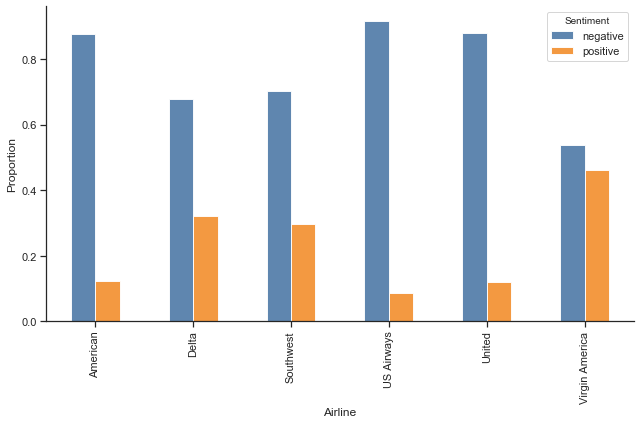

In [79]:
fig, ax = plt.subplots()
(table.T).plot(kind='bar', alpha=0.9, ax=ax)
ax.set_xlabel('Airline')
ax.set_ylabel('Proportion')
ax.legend_.set_title('Sentiment')
plt.tight_layout()
sns.despine()
plt.show()

**4.2 Most common tokens**

The NLTK [FreqDist](http://www.nltk.org/api/nltk.html?highlight=freqdist#nltk.probability) allow us to build a frequency distribution for the tokens. 

In [80]:
fdist = nltk.FreqDist()
for words in train['tokens']:
    for word in words:
            fdist[word] += 1

print(f'Number of unique tokens: {len(fdist)}')

Number of unique tokens: 7826


The most common tokens in the data as a whole are:

In [81]:
fdist.most_common()[:20]

[('!', 2554),
 ('flight', 2330),
 ('@unit', 1727),
 ('@usairway', 1528),
 ('@americanair', 1391),
 ('@southwestair', 895),
 ('thank', 749),
 ('hour', 746),
 ('@jetblu', 740),
 ('get', 737),
 ('servic', 584),
 ('delay', 579),
 ('cancel', 576),
 ('custom', 558),
 ('time', 510),
 ('help', 462),
 ('call', 459),
 ('wait', 442),
 ('...', 442),
 ('hold', 433)]

With a bit of work, we can turn this into a plot.

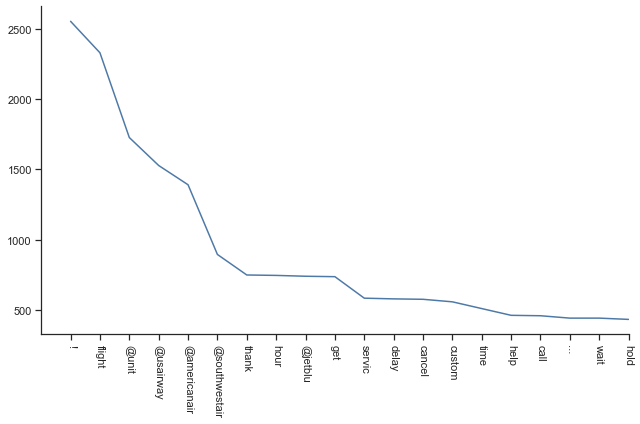

In [82]:
fig, ax = plt.subplots()

y = pd.Series(dict(fdist.most_common()[:20]))
y = y.sort_values(ascending=False)

y.plot()

indexes = np.arange(0, len(y)) # we will place ticks for every word
ax.set_xticks(indexes)
ax.set_xticklabels(y.index, rotation='-90')
ax.set_xlim(-1)

plt.tight_layout()

sns.despine()
plt.show()

**4.3 Most common tokens by sentiment**

Now, let's do the same for positive and negative tweets separately. Here, we compute the proportion of tweets in which the word appears and then sort the tokens accordingly in descending order. 

This analysis gives us important clues for building a classifier. First, nearly half of the positive tweets contain the "thank" word, suggesting that this will be a powerful feature for classification. Not surprisingly, word such as "great", "love", "best", and "good" are among the most frequent in the positive tweets, and do not appear among the most frequent negative tweets. In the same way, "delay", "cancel", and "wait" are among the most frequent for negative tweets and are not among the most frequent among positive tweets.

Interestingly, the exclamation mark is much more common among positive tweets, confirming that it was useful to keep it.  

A third group of words such as "flight" and "service" are frequent among both positive and negative tweets, and thus may not be very useful for classification. 

In [83]:
positives=len(train[train['airline_sentiment']=='positive']) # number of positive tweets in the training data

fdist_positive = nltk.FreqDist()
for words in train[train['airline_sentiment']=='positive']['tokens']:
    for word in np.unique(words): # not counting repeated words this time
            fdist_positive[word] += 1

            
common_positive = pd.Series(dict(fdist_positive))/positives # there is probably a better way to do this
common_positive = common_positive.sort_values(ascending=False)
common_positive.head(20).round(3)

!                 0.592
thank             0.492
@southwestair     0.248
@jetblu           0.222
@unit             0.193
flight            0.180
@americanair      0.158
@usairway         0.123
great             0.114
servic            0.084
love              0.078
help              0.071
@virginamerica    0.070
custom            0.061
fli               0.060
good              0.060
awesom            0.057
much              0.057
best              0.056
guy               0.054
dtype: float64

We can also visualise these results as a word cloud. 

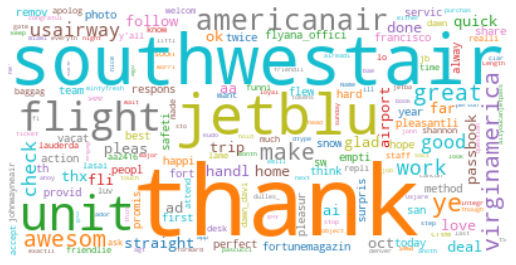

In [84]:
positive_tweets = train[train['airline_sentiment']=='positive']['tokens']

from wordcloud import WordCloud

fig, ax = plt.subplots()
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(str(positive_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [85]:
negatives=len(train[train['airline_sentiment']=='negative'])

fdist_negative = nltk.FreqDist()
for words in train[train['airline_sentiment']=='negative']['tokens']:
    for word in np.unique(words): 
            fdist_negative[word] += 1

common_negative = pd.Series(dict(fdist_negative))/negatives
common_negative = common_negative.sort_values(ascending=False)
common_negative.head(20).round(3)

flight           0.319
@unit            0.291
@usairway        0.268
@americanair     0.236
!                0.178
hour             0.133
get              0.123
@southwestair    0.122
cancel           0.104
delay            0.101
@jetblu          0.097
servic           0.093
custom           0.092
time             0.082
hold             0.080
wait             0.076
call             0.076
help             0.072
...              0.069
bag              0.068
dtype: float64

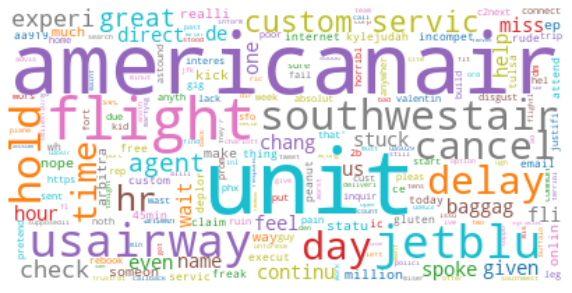

In [86]:
negative_tweets = train[train['airline_sentiment']=='negative']['tokens']

from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(background_color="white", colormap='tab10', max_words=200).generate(str(negative_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**4.4 Which tokens are most discriminative?**

It's helpful to take our analysis one step further and formally ask which tokens are most helpful for distiguishing between positive and negative messages, when used by themselves. In this case,  we can simply use Bayes' rule to compute the estimated class probabilities.

We need auxiliary code. First, we convert the frequency distribution to pandas series for convenience. 

In [87]:
features = pd.Series(dict(fdist))
features = features.sort_values(ascending=False)
features.head()

!               2554
flight          2330
@unit           1727
@usairway       1528
@americanair    1391
dtype: int64

The next cell provides functions that perform the required calculations.

In [88]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import log_loss 

# Builds a dummy variable for the presence of the token
def design_matrix(feature, series):
    X=series.apply(lambda tokens: (feature in tokens))
    X= X.astype(int) 
    return X.values.reshape((-1,1)) # converting to a NumPy matrix, as required

# Computes the training error from using a single token
def training_error(feature):
    X_train = design_matrix(feature, train['tokens'])
    nbc= BernoulliNB().fit(X_train, np.ravel(y_train))
    prob = nbc.predict_proba(X_train)[:,1]
    return log_loss(y_train, prob)

The results are as follows, where we rank the tokens according to the negative log-likelihood loss. 

In [89]:
y_train=train['positive'].values

losses=[]
for feature in features.index[:500]:
    losses.append(training_error(feature))

ranked = pd.Series(losses, index=features.index[:500])
ranked = ranked.sort_values()
ranked.head(20)

thank            0.352262
!                0.399451
great            0.435423
hour             0.439191
love             0.442574
awesom           0.443283
hold             0.444879
:)               0.445310
cancel           0.445428
delay            0.446736
@jetblu          0.447117
@usairway        0.447142
best             0.447376
amaz             0.447485
@southwestair    0.448180
appreci          0.448659
call             0.448795
flight           0.449184
flightl          0.449261
much             0.449794
dtype: float64

### 5. Feature Engineering

As mentioned in the introduction, we will follow a bag of words strategy. Each predictor will be a binary variable indicating the presence of a token in the message. 

It's important to note that this is just one of possible approaches for our document classification problem.  Other extensions adn approaches include using token counts, using n-grams, [tf–idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and [word embeddings](https://en.wikipedia.org/wiki/Word_embedding). 

Even though there are more than 7800 unique tokens, more than half appear only once in the training data. 

In [90]:
features.describe().round(0)

count    7826.0
mean        9.0
std        61.0
min         1.0
25%         1.0
50%         1.0
75%         3.0
max      2554.0
dtype: float64

Tokens with too few appearances in the training data may lead to overfitting. Hence, we set a minimum of five cases for us to include the predictor in the analysis, bringing the number of features down to 1517. We're making an arbitrary choice here, but ideally we can treat this treshold as a hyperparameter. 

In [91]:
features = features[features>=5]
len(features)

1517

Finally, we need to write a function to build the design matrix given a list of features. As a technical detail, we build it as a sparse matrix for memory efficiency. This is because the design matrix can become extremely large in this type of application (millions of entries), but the vast majority of the elements are zero. 

In [92]:
from scipy.sparse import csr_matrix

def design_matrix(features, series):
    X = csr_matrix((len(series),len(features))) # initialise 
    for i in range(len(series)): 
        tokens = series.iloc[i]
        for j, feature in enumerate(features): # scan the list of features
            if feature in tokens: # if the feature is among the tokens, 
                X[i, j]= 1.0
    return X

We now build the final processed versions of the training and test sets.

In [93]:
features = list(ranked.index) # list of tokens

y_train = train['positive'].values
y_test = test['positive'].values

X_train = design_matrix(features, train['tokens'])
X_test = design_matrix(features, test['tokens'])

At this point we may again want to save the current version of the dataset if we want to use it again. Ideally we should save the feature labels too. It's easier to do this by saving the list of features in a separate file, since h5py will not accept the strings as currently encoded.  

In [94]:
import h5py 
f = h5py.File('data/tweets-matrices.h5', 'w')
f.create_dataset('y_train', data=y_train)
f.create_dataset('y_test', data=y_test)
f.create_dataset('X_train', data=X_train.todense(), compression='gzip')
f.create_dataset('X_test', data=X_test.todense(), compression='gzip')
f.close()

In [95]:
pd.DataFrame(features).to_csv('data/tweets_features.csv', index=False)

### 6. Logistic Regression

The Scikit-Learn implementation of [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) uses regularisation by default, with a hyperparameter `C` that is the inverse of the penalty. 

We can do as follows to obtain a logistic regression without regularisation.  

In [96]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=np.inf, solver='lbfgs')
logit.fit(X_train, y_train)

LogisticRegression(C=inf, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Regularisation will be probably be helpful since we have a large number of features. We use the [<TT>LogisticRegressionCV<TT>](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) class, which has in-built  hyperparameter optimisation using cross-validation. 

In [97]:
from sklearn.linear_model import LogisticRegressionCV
logit_l1= LogisticRegressionCV(Cs = 50, penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [98]:
np.sum(np.abs(logit_l1.coef_) == 0.0)

170

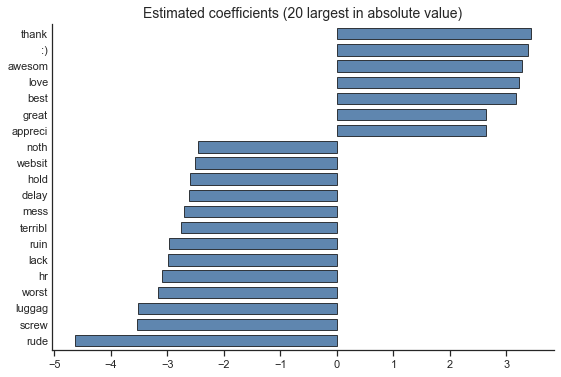

In [99]:
from statlearning import plot_coefficients
plot_coefficients(logit_l1, features)
plt.show()

In [100]:
from sklearn.linear_model import LogisticRegressionCV
logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', solver='lbfgs', scoring='neg_log_loss')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

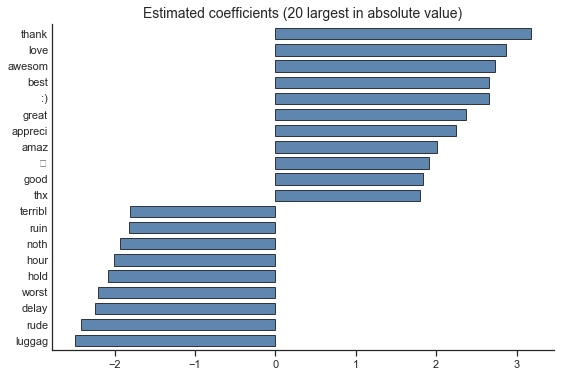

In [101]:
plot_coefficients(logit_l2, features)
plt.show()

### 7. Model Evaluation

We consider two benchmarks for model evaluation. 

In the first we simply classify all messages as negative. Because most tweets are negative, that automatically leads to an accuracy of 83% for classification, which is then what we are trying to improve on.

The second is the naive Bayes method, which is a standard algorithm for this type of problem.

In [102]:
nbc = BernoulliNB() # this method only applies when all the predictors are binary, don't use it otherwise
nbc.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In addition, we consider a model ensemble that is a simple average of the predicted probabilities from the logistic regression algorithm with $\ell^2$ regularisation and the naive Bayes method. 

Here are the results, including common classification metrics. 

In [103]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix

columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['All negative', 'Naive Bayes', 'Logistic', 'Logistic $\ell_1$', 'Logistic $\ell_2$', 'Ensemble']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[None, nbc, logit, logit_l1, logit_l2, None]

y_prob = np.zeros((len(test), len(rows))) # we'll store the probabilities for later

for i, method in enumerate(methods):
    
    if i==0: # all positive
        y_pred = np.zeros(len(y_test))
        y_prob[:, i] = np.mean(y_train)
    elif i==5: # ensemble
        y_prob[:, i] = 0.5*(y_prob[:, 1]+y_prob[:, 4])
        y_pred = (y_prob[:, i] > 0.5).astype(int)
    else:
        y_pred = method.predict(X_test)
        y_prob[:, i] = method.predict_proba(X_test)[:,1]
    
    results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,i])   
    confusion  = confusion_matrix(y_test, y_pred) 
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,4]=  precision_score(y_test, y_pred)

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
All negative,0.170,0.000,1.000,0.500,0.000
Naive Bayes,0.056,0.844,0.964,0.965,0.829
Logistic,0.070,0.785,0.960,0.950,0.802
Logistic $\ell_1$,0.052,0.789,0.981,0.969,0.895
Logistic $\ell_2$,0.052,0.785,0.982,0.970,0.899
Ensemble,0.045,0.835,0.980,0.971,0.896


The results show that the ensemble is the best method with an error rate of 4.5%, followed by the regularised versions of logistic regression with 5.2%. 

The results show that the ensemble has a sensitivity of 83.5% and specificity of 98%. That is, we estimate that it has a 83.5% probability of correctly classifying a positive comment and 98% probability of correctly classifying a negative comment. The precision means that out of the tweets that it classified as positive, 89.6% were in fact positive. 

Comparing the individual models, we note that the naive Bayes method does best in terms of sensitivity, while the regularised logistic regression has better specificity. Remarkably, the average of the two algorithms largely retains their individual advantages. 

Next, we plot the ROC curve. The figure shows that the false positive rate increases sharply if we want to increase the sensitivity beyond the low 80s. 

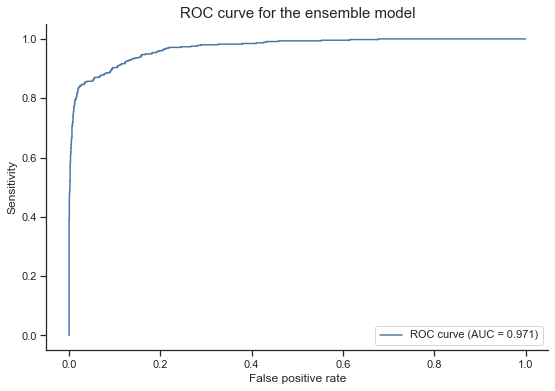

In [104]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_prob[:,-1])
auc = roc_auc_score(y_test, y_prob[:,-1])

fig, ax= plt.subplots()
ax.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc))
ax.set_xlabel('False positive rate')
ax.set_ylabel('Sensitivity')
ax.set_title('ROC curve for the ensemble model', fontsize=15)
sns.despine()
plt.legend()
plt.show()

### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [105]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [107]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')